In [1]:
# install pyevtk which exports data to paraview format
!pip install pyevtk

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# speed of sound in m/s
C = 343

# frequency of interest, for visualization sake
f = 2000.0

def mse(x1, x2):
    """Mean Squared Error (MSE)
    
    Calculates MSE for the input arrays. MSE is a single value.
    """
    # first assert they're the right shape
    assert (x1.shape == x2.shape)
    return np.sum((x1 - x2)**2) / x1.size

def squared_error(x1, x2):
    """Squared Error
    
    Calculates the Squared Error
    """
    return (x1 - x2)**2

def mae(x1, x2):
    """Mean Absolute Error (MAE)
    
    Calculates MAE for the input arrays. MAE is a single value
    """
    # first assert they're the right shape
    assert (x1.shape == x2.shape)
    return np.sum(np.abs(x1 - x2)) / x1.size

def absolute_error(x1, x2):
    """Absolute Error
    
    Calculates the absolute error for the input arrays. Will
    return the same shape as there is no sum. Assumes x1 is the
    truth and x2 is the approximation.
    """
    assert (x1.shape == x2.shape)
    return np.abs(x1 - x2)

def relative_error(x1, x2, use_abs=True):
    """Relative Error
    
    Calculates the relative error for the input arrays. Will
    return the same shape as there is no sum. Assumes x1 is the
    truth and x2 is the approximation.
    """
    # first assert they're the right shape
    assert (x1.shape == x2.shape)
    if use_abs:
        return np.abs(1 - (x2/x1))
    else:
        return 1 - (x2 / x1)
    
def monopole(xx, yy, amp, freq, x, y, phase=0, c=C):
    # note that x and y are the center of the monopole
    # r is the range from the center to the monopole
    # c is the speed of light
    # phase is the starting phase
    # amp is the amplitude
    r = np.sqrt((xx - x)**2 + (yy - y)**2)
    return amp * np.exp(
        1j * (2 * np.pi * freq / c) * r) * np.exp(1j * phase) / (4 * np.pi * r)
    
def monopole3d(xx, yy, zz, amp, freq, x, y, z, phase=0, c=C):
    # note that x and y are the center of the monopole
    # r is the range from the center to the monopole
    # c is the speed of light
    # phase is the starting phase
    # amp is the amplitude
    r = np.sqrt((xx - x)**2 + (yy - y)**2 + (zz - z)**2)
    return amp * np.exp(
        1j * (2 * np.pi * freq / c) * r) * np.exp(1j * phase) / (4 * np.pi * r)


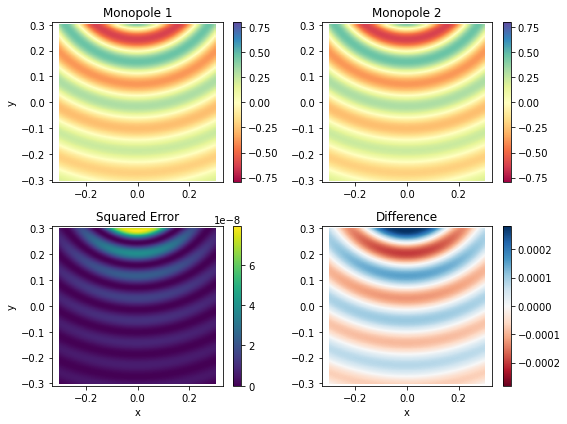

In [3]:
# set our x and y grid
x = np.linspace(-0.3,0.3, 501)
y = np.linspace(-0.3,0.3, 501)
# mesh grid for easy calculations at each point
XX, YY = np.meshgrid(x,y)

# set the first monopole at (0, 0.5) to avoid division by zero
first_monopole = monopole(XX, YY, 2.0, f, x=0, y=0.5)

# set the second monopole at (0.01, 0.51) to move it *slightly* for error analysis
second_monopole = monopole(XX, YY, 2.0, f, x=0.0, y=0.50001)

# get the abs max from both
abs_max = np.max([np.max(np.abs(first_monopole)), np.max(np.abs(second_monopole))])

# build up figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,6))

# first figure is the first monopole
ax = axes[0,0]
c = ax.pcolormesh(XX, YY, np.real(first_monopole), shading="auto", cmap='Spectral', vmin=-abs_max, vmax=abs_max)
fig.colorbar(c, ax=ax)
ax.set_title("Monopole 1")
ax.axis('equal')
ax.set_ylabel("y")

# second figure is the second monopole
ax = axes[0,1]
c = ax.pcolormesh(XX, YY, np.real(second_monopole), shading="auto", cmap='Spectral', vmin=-abs_max, vmax=abs_max)
fig.colorbar(c, ax=ax)
ax.set_title("Monopole 2")
ax.axis('equal')

# third figure is the absolute error
ax = axes[1,0]
c = ax.pcolormesh(XX, YY, squared_error(np.real(first_monopole), np.real(second_monopole)), shading="auto")
fig.colorbar(c, ax=ax)
ax.set_title("Squared Error")
ax.axis('equal')
ax.set_ylabel("y")
ax.set_xlabel("x")

# fourth figure is just the difference
diff_error = np.real(first_monopole) - np.real(second_monopole)
# get the absolute max
the_range = np.max(np.abs(diff_error))
ax = axes[1,1]
c = ax.pcolormesh(XX,YY, diff_error, shading="auto", cmap='RdBu', vmin=-the_range, vmax=the_range)
fig.colorbar(c, ax=ax)
ax.set_title("Difference")
ax.axis('equal')
ax.set_xlabel("x")

plt.tight_layout()
plt.savefig("monopole_error_comparison.png")
plt.show()

In [4]:
# data for paraview
from pyevtk.hl import gridToVTK

# set our x and y grid
x = np.linspace(-0.3,0.3, 201)
y = np.linspace(-0.3,0.3, 201)
z = np.linspace(-0.3,0.3, 201)
# mesh grid for easy calculations at each point
XX, YY, ZZ = np.meshgrid(x, y, z)

# set the first monopole at (0, 0.5) to avoid division by zero
first_monopole = monopole3d(XX, YY, ZZ, 2.0, f, x=0, y=0.5, z=0.0).real

# set the second monopole at (0.01, 0.51) to move it *slightly* for error analysis
second_monopole = monopole3d(XX, YY, ZZ, 2.0, f, x=0.0, y=0.50001, z=0.0).real

sq_error = squared_error(first_monopole, second_monopole)

diff_error = first_monopole - second_monopole

gridToVTK("./monopole_tests", x, y, z, pointData = {
    "monopole1": np.ascontiguousarray(first_monopole),
    "monopole2": np.ascontiguousarray(second_monopole),
    "squaredError": np.ascontiguousarray(sq_error),
    "diffError": np.ascontiguousarray(diff_error)
})

print("saved")
# at this point, you can import the data into paraview

saved
